In [4]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Models and modeling tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

# KERAS
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [5]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')


# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')
target.replace({'yes':1,'no':0}, inplace=True)


# Replace binary columns 1/0
for col in ['default', 'housing', 'loan']:
    features[col].replace({'yes':1,'no':0}, inplace=True)

    
# Encode small categorical columns
cols = ['marital', 'education', 'contact']

enc = OneHotEncoder(sparse=False, dtype=int)
encoded = enc.fit_transform(features[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDF = pd.DataFrame(encoded)
encDF.columns = encNames

features = features.drop(columns=cols)
features = pd.concat([features, encDF], axis=1)


# Encode large categorical columns
cols = ['month', 'job']

enc = OneHotEncoder(sparse=False)
encoded = enc.fit_transform(features[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDF = pd.DataFrame(encoded)
encDF.columns = encNames

features = features.drop(columns=cols)
features = pd.concat([features, encDF], axis=1)


# Remove duration (this is not a reasonable thing to have in the model as it should tell success/failure well?)
#features = features.drop(columns=['duration'])

In [6]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(features.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(features,
                    target,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
3200/3200 [==============================] - 12s 4ms/step - loss: 1.4770 - accuracy: 0.9091 - val_loss: 0.6255 - val_accuracy: 0.8785
Epoch 2/80
3200/3200 [==============================] - 14s 4ms/step - loss: 0.3253 - accuracy: 0.9327 - val_loss: 0.4423 - val_accuracy: 0.8752
Epoch 3/80
3200/3200 [==============================] - 17s 5ms/step - loss: 0.2205 - accuracy: 0.

In [8]:
oversample = SMOTE()
ovFeatures, ovTarget = oversample.fit_resample(features, target)

In [9]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(ovFeatures.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(ovFeatures,
                    ovTarget,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                672       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
5937/5937 [==============================] - 7s 1ms/step - loss: 1.1074 - accuracy: 0.7731 - val_loss: 0.1239 - val_accuracy: 0.9474
Epoch 2/80
5937/5937 [==============================] - 7s 1ms/step - loss: 0.4014 - accuracy: 0.8628 - val_loss: 0.2453 - val_accuracy: 0.9068
Epoch 3/80
5937/5937 [==============================] - 7s 1ms/step - loss: 0.3618 - accuracy: 0.8

In [13]:
x_initial, x_test, y_initial, y_test = train_test_split(features, target, test_size=0.10, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_initial, y_initial, test_size=0.10, random_state=2)

oversample = SMOTE()
ovFeatures, ovTarget = oversample.fit_resample(x_train, y_train)

In [80]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(ovFeatures.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(ovFeatures,
                    ovTarget,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_data=(x_valid, y_valid),
                    shuffle=True,
                    verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                672       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
6016/6016 [==============================] - 7s 1ms/step - loss: 2.9250 - accuracy: 0.7534 - val_loss: 1.2467 - val_accuracy: 0.7783
Epoch 2/80
6016/6016 [==============================] - 7s 1ms/step - loss: 0.8319 - accuracy: 0.8590 - val_loss: 0.3006 - val_accuracy: 0.9208
Epoch 3/80
6016/6016 [==============================] - 7s 1ms/step - loss: 0.5760 - accuracy: 0.8

In [81]:
y_predict = model.predict(x_test)

In [82]:
score = y_predict.round(0).flatten() - np.asarray(y_test)

In [83]:
np.asarray(np.unique(y_predict.round(0), return_counts=True)).T

array([[0.000e+00, 3.766e+03],
       [1.000e+00, 2.340e+02]])

In [84]:
np.asarray(y_test)

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
np.asarray(np.unique(score, return_counts=True)).T

array([[-1.000e+00,  1.790e+02],
       [ 0.000e+00,  3.718e+03],
       [ 1.000e+00,  1.030e+02]])

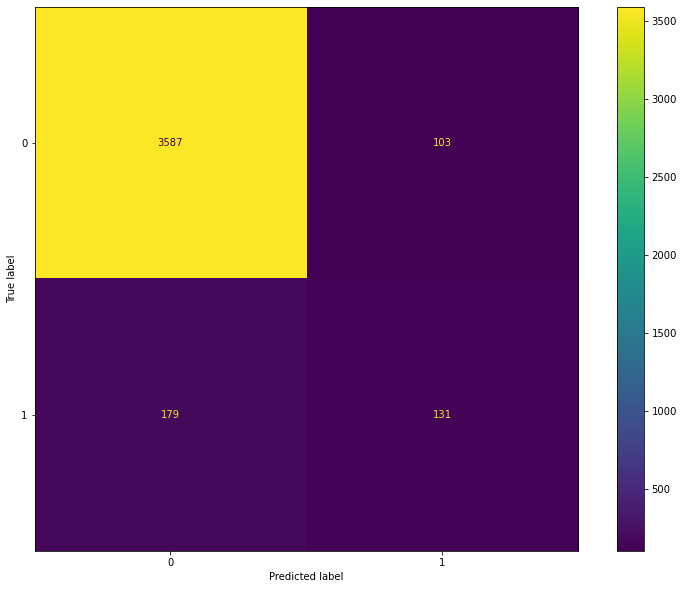

In [114]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predict.round(0))
ConfusionMatrixDisplay(cm).plot()

In [87]:
pd.DataFrame(y_predict.round(0).flatten()).value_counts()

0.0    3766
1.0     234
dtype: int64

In [88]:
y_test.value_counts()

0    3690
1     310
Name: y, dtype: int64

In [ ]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(ovFeatures.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(ovFeatures,
                    ovTarget,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_data=(x_valid, y_valid),
                    shuffle=True,
                    verbose=1)

In [90]:
from keras.utils.vis_utils import plot_model
#model = Sequential()
#model.add(Dense(2, input_dim=1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
plot_model(model, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [94]:
dir(model.layers[0])

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_batch_input_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_dtype',
 '_compute_dtype_object',
 '_dedup_weights',
 '_default_training_arg',
 '_deferred_dependencies',
 '_dty

In [111]:
model.layers[2].weights

[<tf.Variable 'dense_16/kernel:0' shape=(16, 1) dtype=float32, numpy=
 array([[ 0.05061869],
        [-0.04989836],
        [-0.08220726],
        [ 0.04803583],
        [ 0.03516577],
        [-0.0570446 ],
        [-0.2971733 ],
        [ 0.23740578],
        [-0.08580729],
        [ 0.16264603],
        [-0.09911088],
        [ 0.23289838],
        [-0.00273622],
        [ 0.0462644 ],
        [-0.22101545],
        [ 0.12661459]], dtype=float32)>,
 <tf.Variable 'dense_16/bias:0' shape=(1,) dtype=float32, numpy=array([1.2880929], dtype=float32)>]

In [113]:
f1_score(y_test, y_predict.round(0))

0.48161764705882354

In [172]:
from keras.metrics import RecallAtPrecision
from sklearn.model_selection import KFold

def buildNetwork(numLayers=2, layerSizes=[0,0]):
    neuNet = Sequential()
    # Input layer
    neuNet.add(Dense(16, input_shape=(layerSizes[0],), activation='relu'))
    # Internal Hidden layers
    for i in range(1, numLayers-1):
        neuNet.add(Dense(layerSizes[i], activation='relu'))
    # Output layer
    neuNet.add(Dense(layerSizes[-1], activation='sigmoid'))
    neuNet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])
    return neuNet



x_initial, x_test, y_initial, y_test = train_test_split(features, target, test_size=0.20, random_state=1)
x_initial = x_initial.reset_index(drop=True)
y_initial = y_initial.reset_index(drop=True)

kf = KFold(n_splits=5, random_state=100, shuffle=True)
cnt = 1
modelData = {}
for train_index, valid_index in kf.split(x_initial):
    modelData[cnt] = {}
    x_train, x_valid = x_initial.iloc[train_index], x_initial.iloc[valid_index]
    y_train, y_valid = y_initial.iloc[train_index], y_initial.iloc[valid_index]

    oversample = SMOTE()
    ovFeatures, ovTarget = oversample.fit_resample(x_train, y_train)

    es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

    modelA = buildNetwork(numLayers=3, layerSizes=[ovFeatures.shape[1],16,16,1])
    modelB = buildNetwork(numLayers=3, layerSizes=[ovFeatures.shape[1],ovFeatures.shape[1],16,1])
    modelC = buildNetwork(numLayers=4, layerSizes=[ovFeatures.shape[1],ovFeatures.shape[1],16,16,1])

    print ("Training on fold", cnt)
    historyA = modelA.fit(ovFeatures, ovTarget, callbacks=[es], epochs=80, batch_size=1000, 
                        validation_data=(x_valid, y_valid), shuffle=True, verbose=False)
    print ("Finished training model A on fold", cnt)
    historyB = modelB.fit(ovFeatures, ovTarget, callbacks=[es], epochs=80, batch_size=1000, 
                        validation_data=(x_valid, y_valid), shuffle=True, verbose=False)
    print ("Finished training model B on fold", cnt)
    historyC = modelC.fit(ovFeatures, ovTarget, callbacks=[es], epochs=80, batch_size=1000 , 
                        validation_data=(x_valid, y_valid), shuffle=True, verbose=False)
    print ("Finished training model C on fold", cnt)
    print ("Finished training on fold", cnt)

    modelData[cnt]['A'] = {'model': modelA, 'history': historyA}
    modelData[cnt]['B'] = {'model': modelB, 'history': historyB}
    modelData[cnt]['C'] = {'model': modelC, 'history': historyC}
    
    cnt = cnt+1
    


#y_predict = model.predict(x_test)
#cm = confusion_matrix(y_test, y_predict.round(0))
#ConfusionMatrixDisplay(cm).plot()

Training on fold 1
Finished training model A on fold 1
Finished training model B on fold 1
Finished training model C on fold 1
Finished training on fold 1
Training on fold 2
Finished training model A on fold 2
Finished training model B on fold 2
Finished training model C on fold 2
Finished training on fold 2
Training on fold 3
Finished training model A on fold 3
Finished training model B on fold 3
Finished training model C on fold 3
Finished training on fold 3
Training on fold 4
Finished training model A on fold 4
Finished training model B on fold 4
Finished training model C on fold 4
Finished training on fold 4
Training on fold 5
Finished training model A on fold 5
Finished training model B on fold 5
Finished training model C on fold 5
Finished training on fold 5


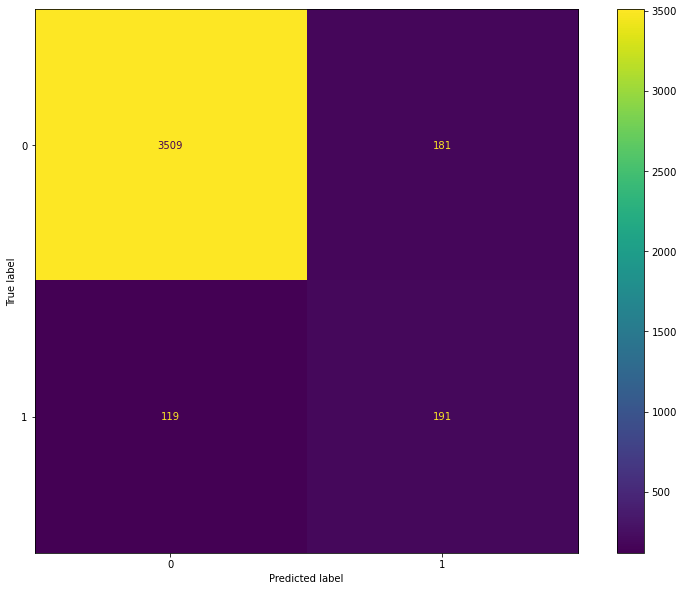

In [134]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_predict = model.predict(x_test)
cm = confusion_matrix(y_test, y_predict.round(0))
ConfusionMatrixDisplay(cm).plot()

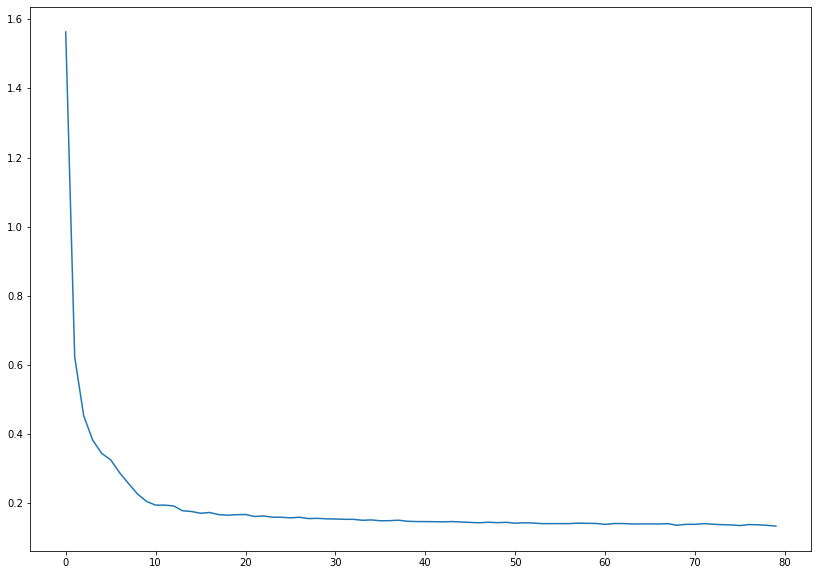

In [139]:
plt.plot(history.history['loss'])
plt.show()

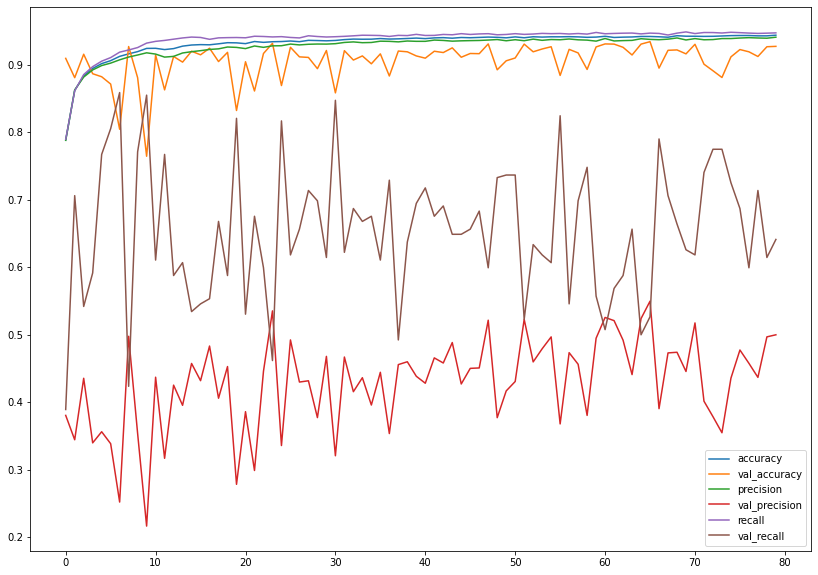

In [146]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.legend()
plt.show()

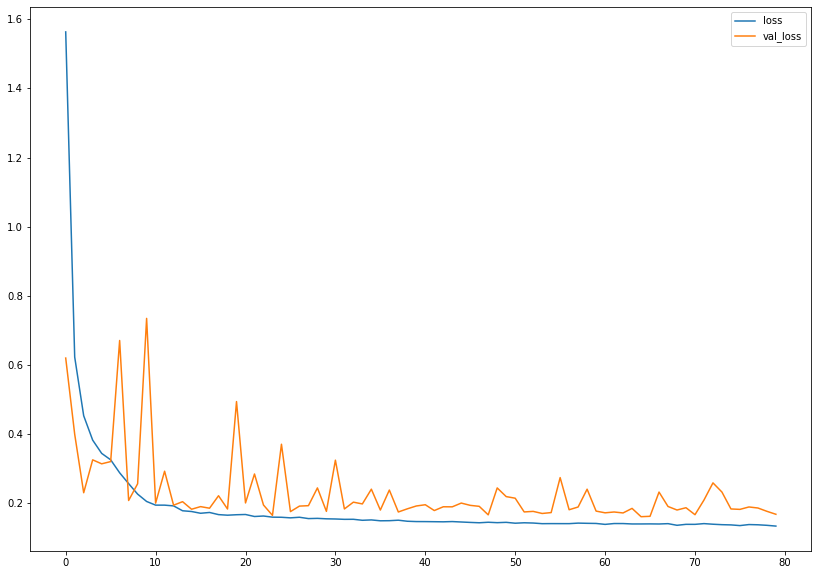

In [147]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [200]:
def plots(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['precision'], label='precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.plot(history.history['recall'], label='recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    
def evaluate(modelData, key='A'):
    cnt = 1
    for train_index, valid_index in kf.split(x_initial):
        x_train, x_valid = x_initial.iloc[train_index], x_initial.iloc[valid_index]
        y_train, y_valid = y_initial.iloc[train_index], y_initial.iloc[valid_index]
        
        foldModel = modelData[cnt][key]['model']
        y_pred = foldModel.predict(x_valid)  
          
        cm = confusion_matrix(y_valid, y_pred.round(0))
        
        if (cnt == 1):
            confMat = cm
        else:
            confMat = confMat + cm
            
        cnt = cnt + 1
        
    return confMat

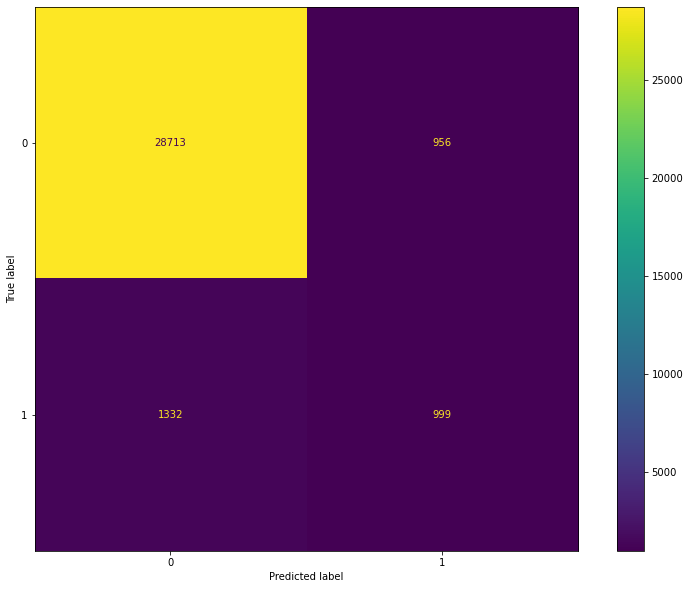

In [207]:
modelA = evaluate(modelData, key='A')
ConfusionMatrixDisplay(modelA).plot()

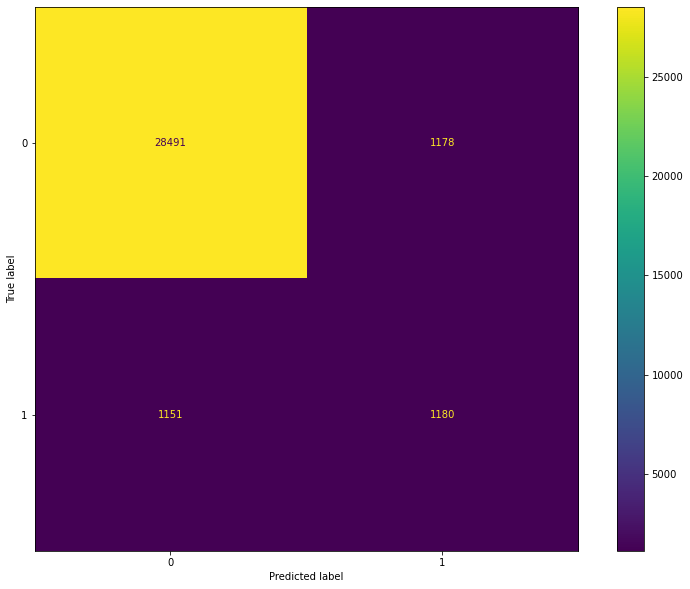

In [208]:
modelB = evaluate(modelData, key='B')
ConfusionMatrixDisplay(modelB).plot()

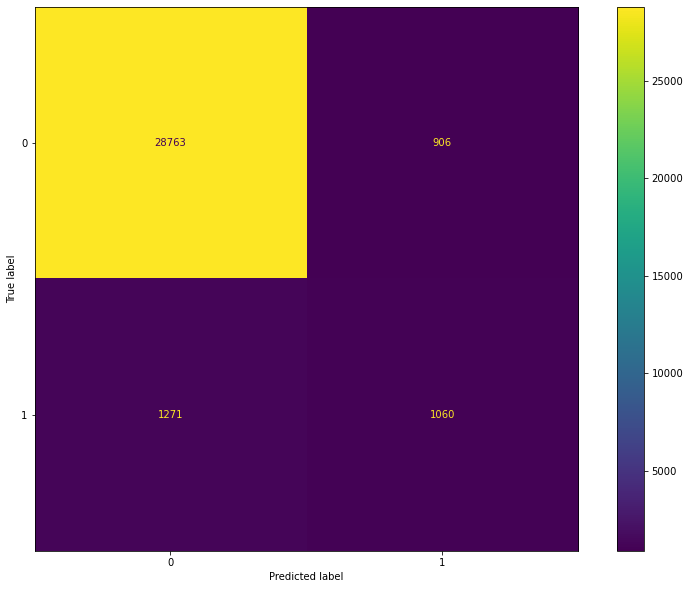

In [209]:
modelC = evaluate(modelData, key='C')
ConfusionMatrixDisplay(modelC).plot()

Epoch 1/80
5341/5341 [==============================] - 8s 1ms/step - loss: 2.3503 - accuracy: 0.7389 - recall: 0.7148 - precision: 0.7041 - val_loss: 2.3567 - val_accuracy: 0.6550 - val_recall: 0.6550 - val_precision: 1.0000
Epoch 2/80
5341/5341 [==============================] - 6s 1ms/step - loss: 1.0413 - accuracy: 0.8204 - recall: 0.7908 - precision: 0.8012 - val_loss: 0.6626 - val_accuracy: 0.7321 - val_recall: 0.7321 - val_precision: 1.0000
Epoch 3/80
5341/5341 [==============================] - 7s 1ms/step - loss: 0.4922 - accuracy: 0.8686 - recall: 0.8535 - precision: 0.8532 - val_loss: 0.4575 - val_accuracy: 0.8487 - val_recall: 0.8487 - val_precision: 1.0000
Epoch 4/80
5341/5341 [==============================] - 6s 1ms/step - loss: 0.3167 - accuracy: 0.8961 - recall: 0.8903 - precision: 0.8762 - val_loss: 0.1900 - val_accuracy: 0.9329 - val_recall: 0.9329 - val_precision: 1.0000
Epoch 5/80
5341/5341 [==============================] - 6s 1ms/step - loss: 0.2553 - accuracy: 0

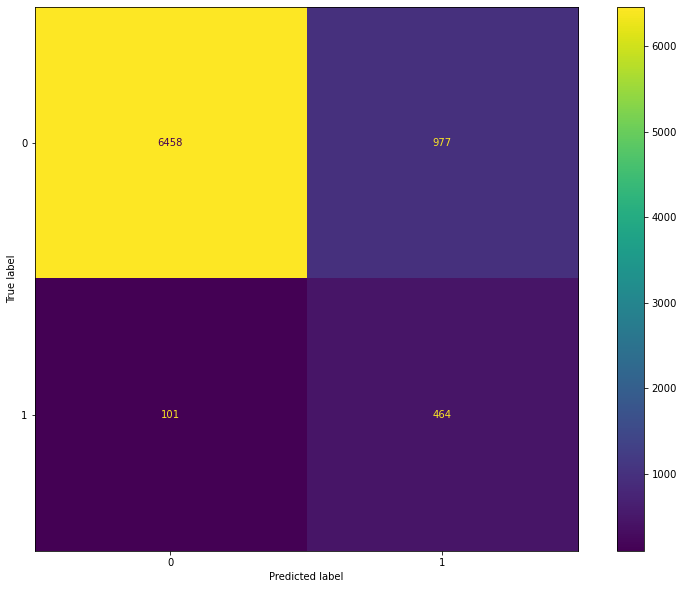

In [211]:
oversample = SMOTE()
ovFeatures, ovTarget = oversample.fit_resample(x_initial, y_initial)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

model = buildNetwork(numLayers=3, layerSizes=[ovFeatures.shape[1],ovFeatures.shape[1],16,1])

hist = model.fit(ovFeatures, ovTarget, callbacks=[es], epochs=80, batch_size=10, 
                                        validation_split=0.1, shuffle=True, verbose=True)

y_predTest = model.predict(x_test)    
cm = confusion_matrix(y_test, y_predTest.round(0))
ConfusionMatrixDisplay(cm).plot()

In [197]:
y_pred = modelData[2]['A']['model'].predict(x_valid)    
cm1 = confusion_matrix(y_valid, y_pred.round(0))

In [198]:
cm1

array([[5781,  149],
       [ 298,  172]])

In [196]:
cm

array([[5781,  149],
       [ 298,  172]])

In [199]:
cm + cm1

array([[11562,   298],
       [  596,   344]])

In [7]:
## Activation Function  -- relu, sigmoid
## Dropout -- Randomly reduces the (weight based dropout, neuron removal) -- overfitting
## Optimizers -- Adam, 


## Functions that can help iterate faster

## Data Augmentation -- SMOTE similar -- 

## Pretrain AI image models -- MNIST

## GANN

In [26]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import np_utils

# Load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Rescale 2D array of pixels to 1D input array 
X_train = X_train.reshape(X_train.shape[0], 
                          X_train.shape[1]*X_train.shape[2])

X_test = X_test.reshape(X_test.shape[0], 
                        X_test.shape[1]*X_test.shape[2])

# Convert output datapoints to array with 1 in correct digit
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [29]:
model = Sequential()
model.add(Dense(784, input_shape=(784,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

model.summary()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

history = model.fit(X_train, y_train, batch_size=1000, epochs=20)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_9 (Dense)              (None, 28)                2828      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                290       
Total params: 697,058
Trainable params: 697,058
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
60/60 [==============================] - 4s 60ms/step - loss: 14.4022 - accuracy: 0.6260
Epoch 2/20
60/60 [==============================] - 3s 58ms/step - loss: 0.6617 - accuracy: 0.9162
Epoch 3/20
60/60 [=============================

In [31]:
y_pred = model.predict(X_test)

In [39]:
y_pred[0]

array([9.9640644e-01, 7.4350834e-04, 5.3347999e-06, 1.0000000e+00,
       1.3185874e-07, 3.1856298e-03, 9.9731684e-01, 1.0000000e+00,
       4.7733560e-05, 9.9999970e-01], dtype=float32)

In [40]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)